In [19]:
import pandas as pd
import numpy as np
import collections
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import preprocessing
from sklearn import metrics

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

#for the NN
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras import backend as K
import tensorflow as tf
from keras.optimizers import SGD, RMSprop
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score

#for inbalance issues 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from collections import Counter
from matplotlib import pyplot 
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.under_sampling import OneSidedSelection
from imblearn.under_sampling import NearMiss
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import TomekLinks

#imports for XGBoost
import xgboost as xgb 
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import plot_tree
from yellowbrick.classifier import ClassBalance, ROCAUC, ClassificationReport, ClassPredictionError
from keras.utils.vis_utils import plot_model

In [2]:
def prepare_inputs_and_outputs(data):
    
    # Prepare & save the inputs and outputs features
    features = data.drop(['isFraud','TransactionID'], axis = 1)
    labels = data[['isFraud']]
    
    return features, labels

In [3]:
def get_missing_data_percentage(data):
    
    # where mvp = missing value percentages
    mvp = data.isnull().sum() * 100 / len(data)
    mvp = pd.DataFrame({'Feature': data.columns,'Percentage': mvp})
    
    return mvp.sort_values(by ='Percentage', ascending=False)

In [4]:
def drop_high_missing_data_columns(mvd, data, threshold):
    # Where "mvd" = missing value data
    # Get names of indexes for which column missing data is over 50%
    high_missing_data_cols = mvd[mvd['Percentage'] > threshold].index

    for col_name in range(len(high_missing_data_cols)):
        del data[high_missing_data_cols[col_name]] # Delete rows from dataFrame??? or columns
    
    return data

In [5]:
def drop_one_value_columns(data):
    
    # Drop columns with only 1 unique value.
    for column in data.columns:
        if len(data[column].unique()) == 1:
            #print(traindata[column].name)
            data.drop(column,inplace=True,axis=1)
            
    return data

In [6]:
def getCategoricalFeatures(data):
    columns = list(data)
    result = []
    for c in columns:
        if data.dtypes[c] == np.object:
            result.append(c)
    return data[result]

def getNumericalFeatures(data):
    columns = list(data)
    result = []
    for c in columns: 
        if data.dtypes[c] != np.object:
            result.append(c) 
    return data[result]

In [7]:
def drop_high_correlation_features(data, threshold):

    corr_matrix = data.corr()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(abs(upper[column]) > threshold)]
    data = data.drop(columns = to_drop)
    
    return data

In [8]:
def label_encode_categorical_features(data):
    encoder_dict = collections.defaultdict(LabelEncoder)
    data = data.apply(lambda x: encoder_dict[x.name].fit_transform(x))
    return data

In [9]:
def split_data(features, labels):
    
    # Data Splitting: 60% for training, 20% for validation and 20% for testing.
    X_train, X_test, Y_train, y_test = train_test_split(features, labels, test_size=0.4)
    X_validation, X_test, Y_validation, y_test = train_test_split(X_test, y_test, test_size=0.5)
    
    return X_train, Y_train, X_test, y_test, X_validation, Y_validation

In [10]:
def selectkbestfeatures(X_train, Y_train, X_validation, X_test, numberOfFeatures):

    fit = SelectKBest(score_func=f_classif, k=numberOfFeatures).fit(X_train, Y_train)

    X_train = fit.transform(X_train)
    X_validation = fit.transform(X_validation)
    X_test = fit.transform(X_test)

    # Get column names from the best features
    X_train_cols = fit.get_support(indices=True)
    X_validation_cols = fit.get_support(indices=True)
    X_test_cols = fit.get_support(indices=True)

    X_train = pd.DataFrame(X_train, columns=X_train_cols)
    X_validation = pd.DataFrame(X_validation, columns=X_validation_cols)
    X_test = pd.DataFrame(X_test, columns=X_test_cols)

    # Create new dataframes with the column names
    #X_train = X_train.iloc[:,X_train_cols]
    #X_validation = X_validation.iloc[:,X_validation_cols]
    #X_test = X_test.iloc[:,X_test_cols]

    return X_train, X_validation, X_test

In [11]:
def evaluate_model(name, model, features, labels):
    
    start = time()
    pred = model.predict(features)
    end = time()
    
    # Print the confusion matrix
    print(metrics.confusion_matrix(labels, pred))

    # Print the precision and recall, among other metrics
    print(metrics.classification_report(labels, pred, digits=3))
    
    print(name+" Accuracy - "+str(round(accuracy_score(labels, pred), 3) * 100)+"%")
    print(name+" Precision - "+str(round(precision_score(labels, pred, average='micro'), 3) * 100)+"%")
    print(name+" Recall - "+str(round(recall_score(labels, pred, average='micro'), 3) * 100)+"%")
    print(name+" F1 Score - "+str(round(f1_score(labels, pred, average='micro'), 3) * 100)+"%")
    print(name+" Latency - "+str(round((end - start) * 1000, 1))+"ms \n")

In [20]:
#------------------------------------------------Data Sampling Functions-------------------------------------#
#These are different functions created to perform oversampling and undersampling on the data to help deal with the data inbalance
#Multiple methods where attempted with the most sucessful being the SMOTE oversampling and the combination of SMOTE and Tomek for both oversampling and undersampling 
# Authors: Lucas Dillistone 
#------------------------------------------------------------------------------------------------------------#

#SMOTE Oversampling
#takes three inputs K for the nearest neighbors, x for the predictor data and y for the result data 
#will return two outputs one for the new predictor data and the other for the new result data 
def smote(K,x,y):
    seed=100 
    sm=SMOTE(sampling_strategy='auto', k_neighbors=K, random_state=seed)
    X_res, y_res=sm.fit_resample(x,y)
    return X_res, y_res

#ADASYN Oversampling 
#Takes two inputs one for the predictor data and one for the response data
#will return two outputs one for the balanced predictor data and the other for the balanced response data  
def ada(x,y):
    adas=ADASYN()
    c_res,d_res=adas.fit_resample(x,y)
    return c_res, d_res
#Editied Nearest Neighbours undersampling 
#Takes three inputs K for the number of nearest neighbors x for the predictor data and y for the response data 
#will return two outputs a for the sampled predictor data and b for the balanced response data 
def ENN(K, x,y):
    undersample= EditedNearestNeighbours(n_neighbors=K)
    a,b=undersample.fit_resample(x,y)
    return a, b

#Condensed Nearest Neighbors undersampling This function takes quite a long time to run and does not have great results 
#Takes three inputs k for the nearest neighbors x for the predictor data and y for the response data 
#returns two output values X for the sampled predictor data and Y for the sampled response data 
def CNN(K,x,y):#relativly slow so do not use again 
    undersample=CondensedNearestNeighbour(n_neighbors=K)
    X,Y=undersample.fit_resample(x,y)
    return X,Y

#One sided undersampling 
#Takes four inputs n for the number of nearest neighbors, s for the number of seeds, x for the predictor data and y for the response data 
#returns two output variables X for the sampled predictor data and Y for the sampled response data 
def OSS(n,s,x,y):
    undersample=OneSidedSelection(n_neighbors=n, n_seeds_S=s)
    X,Y=undersample.fit_resample(x,y)
    return X,Y

#Near Miss undersampling 
#takes three inputs n to select a version to use from 1-3 althogh 2 takes a huge amount of processing, x is the predictor data and y for the response data 
#returns two output values X for the sampled predictor values and Y for the sampled response values 
def NM(n,x,y):# DO NOT USE v 2 TOOK UP 54G of RAM
    undersample=NearMiss(version=3,n_neighbors_ver3=n)
    X,Y=undersample.fit_resample(x,y)
    return X,Y

#A combination of under and over sampling using SMOTE and Edited Nearest Neighbors or SMOTE and Tomek  
#takes two inputs x for the predictor data and y for the response data 
#will return two values retx for the sampled predictor data and rety for the sampled response data 
def comb(x,y):
    #resample = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'))#Uncomment for use of edited neatest neighbors 
    resample = SMOTETomek(tomek=TomekLinks(sampling_strategy='majority'))
    retx,rety=resample.fit_resample(x,y)
    return retx, rety

This will be the start of the data analytics and will make use of the above functions 

In [12]:
# read and combine train data by the TransactionID
#this has been changed to read from the local machine instad of from google drive as is done with colab 
train_identity = pd.read_csv("D:\School\Fifth Year\Large Scale Data Analytics\Project\ieee-fraud-detection\\train_identity.csv")
train_transaction = pd.read_csv("D:\School\Fifth Year\Large Scale Data Analytics\Project\ieee-fraud-detection\\train_transaction.csv")
#combine the data so we can go through the whole thing 
traindata = pd.merge(train_transaction,train_identity, on='TransactionID', how='left',left_index=True,right_index=True)

In [13]:
# Separate Features & Labels
train_features, train_labels = prepare_inputs_and_outputs(traindata)#used to be at the top but I moved it in order to have the

In [14]:
# [PREPROCESSING STAGE 1] - DATA CLEANING

# Examine the percentage of missing data for all feature in the training data
allFeaturesMissingData = get_missing_data_percentage(train_features)

# Drop features with a missing data percentage above the specified threshold
train_features = drop_high_missing_data_columns(allFeaturesMissingData, train_features, 70)

# Drop features with only 1 distinct value, extremely high or extremely low correlation
train_features = drop_one_value_columns(train_features)
train_features = drop_high_correlation_features(train_features, 0.80)

# Extract the numerical & categorical features from training features
numericalFeatures = getNumericalFeatures(train_features)
categoricalFeatures = getCategoricalFeatures(train_features)

# Get the percentage of missing data for both numerical & categorical features
numericalFeaturesMissingData = get_missing_data_percentage(numericalFeatures)
categoricalFeaturesMissingData = get_missing_data_percentage(categoricalFeatures)


# Impute categorical missing values with "X" and numerical missing values with column mean
numericalFeatures = numericalFeatures.fillna(numericalFeatures.mean(), inplace=False)
categoricalFeatures = categoricalFeatures.fillna("X")

 #Update missing data and ensure none exists
numericalFeaturesMissingData = get_missing_data_percentage(numericalFeatures)
categoricalFeaturesMissingData = get_missing_data_percentage(categoricalFeatures)




In [15]:
# [PREPROCESSING STAGE 2] - DATA TRANSFORMATION 

# Numerically represent the categorical features using label encoding
categoricalFeatures = label_encode_categorical_features(categoricalFeatures)

# Update training features by replacing the initial data with the imputed data
train_features = pd.concat([numericalFeatures, categoricalFeatures], axis=1)


# Further split the training data into a train and test sets
X_train, Y_train, X_test, Y_test, X_validation, Y_validation = split_data(train_features, train_labels)

# Feature Selection using SelectKBest
X_train, X_validation, X_test = selectkbestfeatures(X_train, Y_train, X_validation, X_test, 50)

# Feature Scaling using Standardization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

In [21]:
# [PREPROCESSING STAGE 3] - DATA REDUCTION (USING PCA or LDA) (focus here next)

from sklearn.decomposition import PCA

pca = PCA(n_components=25).fit(X_train)

X_train_pca = pca.transform(X_train)
X_validation_pca = pca.transform(X_validation)
X_test_pca = pca.transform(X_test)

X_train = pd.DataFrame(data = X_train_pca)
X_validation = pd.DataFrame(data = X_validation_pca)
X_test = pd.DataFrame(data = X_test_pca)

comb_x, comb_y=comb(X_train,Y_train) 

[0]	validation_0-auc:0.77094
Will train until validation_0-auc hasn't improved in 100 rounds.
[50]	validation_0-auc:0.83692
[100]	validation_0-auc:0.84126
[150]	validation_0-auc:0.84438
[200]	validation_0-auc:0.84763
[250]	validation_0-auc:0.84962
[300]	validation_0-auc:0.85152
[350]	validation_0-auc:0.85331
[400]	validation_0-auc:0.85471
[450]	validation_0-auc:0.85585
[500]	validation_0-auc:0.85706
[550]	validation_0-auc:0.85811
[600]	validation_0-auc:0.85901
[650]	validation_0-auc:0.85978
[700]	validation_0-auc:0.86038
[750]	validation_0-auc:0.86100
[800]	validation_0-auc:0.86157
[850]	validation_0-auc:0.86214
[900]	validation_0-auc:0.86255
[950]	validation_0-auc:0.86300
[1000]	validation_0-auc:0.86338
[1050]	validation_0-auc:0.86373
[1100]	validation_0-auc:0.86396
[1150]	validation_0-auc:0.86417
[1200]	validation_0-auc:0.86437
[1250]	validation_0-auc:0.86464
[1300]	validation_0-auc:0.86477
[1350]	validation_0-auc:0.86502
[1400]	validation_0-auc:0.86522
[1450]	validation_0-auc:0.8653

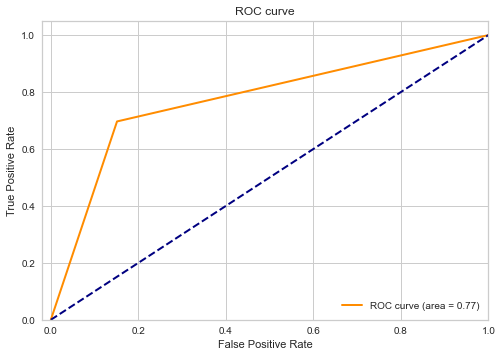

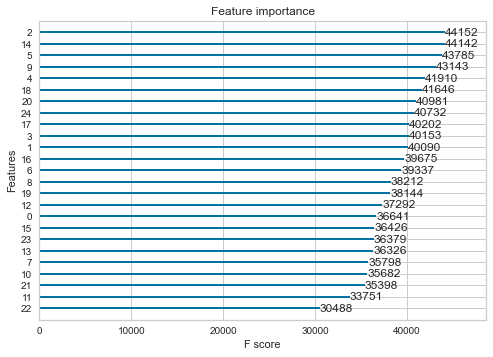

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.248039 to fit
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.25388 to fit


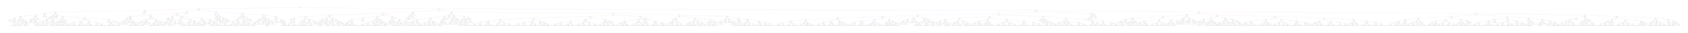

   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.904266       0.000460       0.889636      0.000861
1        0.926028       0.002851       0.914132      0.003291
2        0.932394       0.002021       0.921249      0.002823
3        0.935759       0.001797       0.925317      0.002364
4        0.937998       0.001271       0.928134      0.001679
5        0.939262       0.000906       0.929658      0.001421
6        0.940096       0.000964       0.930668      0.001589
7        0.940686       0.000911       0.931439      0.001420
8        0.941117       0.000755       0.931964      0.001215
9        0.941529       0.000724       0.932452      0.001145


In [37]:
#------------------------------------------------XGBoost Functions-------------------------------------------#
#These are functions made to use the XGBoost model to train and test the data 
#Additional functions are made to plot the data and find the results  
# Authors: Lucas Dillistone 
#------------------------------------------------------------------------------------------------------------#

#Function to build the xgmodel with the parameters specified. Different parts may be commented and uncommented based on what you are trying to build 
#will take 4 inputs predictors for the predictor data, response for the response data, test_pred for the validation prediction data and test_resp for the validation response data
#this function will only return the trained model 
def XGModel(predictors,response,test_pred,test_resp):
        xg_reg=xgb.XGBRegressor(objective='reg:logistic',colsample_bytree=0.15, learning_rate=0.01,max_depth=12,n_estimators=2000,subsample=0.4 ,tree_method='gpu_hist',                       eval_metric='auc',alpha=10)#create the regressor model with specific values 

        """
        xg_reg = xgb.XGBClassifier(  # a classifyer XGBoost model with specific values to be used later 
                n_estimators=2000,
                max_depth=12, 
                objective='reg:logistic',
                learning_rate=0.1, 
                subsample=0.8,
                colsample_bytree=0.15, 
                missing=-1, 
                eval_metric='auc',
                # USE CPU
                nthread=4,
                tree_method='hist' 
                # USE GPU
                #tree_method='gpu_hist' 
                )
         """


        xg_reg.fit(predictors, response, eval_set=[(test_pred,test_resp)],verbose=50, early_stopping_rounds=100)#fit thr XGBoost model with the data we are looking for along with a validation set it will print the result of every 50 trials and will stop if there has been no improvement after 100 trials 

        return xg_reg

#this function will display the auc and RMSE scores of a model that has been trained on data we have specified it will then plot the AUC curve 
# it will take three inputs Model which is the model that was trained, X_dat which is the predictor data and Y_dat which is the response data 
#there will be no returns as the function will be printing 
def XGAccuracy(Model,X_dat,Y_dat):
        pred=Model.predict(X_dat)
        pred=[round(value) for value in pred]
        rmse=np.sqrt(mean_squared_error(Y_dat,pred))
        print("RMSE: %f"%(rmse))
        print("AUC: %.4f"%(roc_auc_score(Y_dat,pred)))


        fpr, tpr, _=roc_curve(Y_dat, pred)
        roc_auc=auc(fpr, tpr)
        plt.figure()
        lw = 2
        plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([-0.02, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC curve')
        plt.legend(loc="lower right")
        plt.show()


#this function will create two plots showing the feature importance of the features used in the model 
#it will take one input variable with the model 
#there will be no return as the objective is to print the plots 
def XGFeatureImportance(mod):
        #pyplot.bar(range(len(xg_reg.feature_importances_)), xg_reg.feature_importances_)
        #pyplot.show()

        xgb.plot_importance(xg_reg)
        pyplot.show()




#This function will print out a tree from the XGBoost model but unless the depth is very low it will not be enough to display 
#this will only take one input which is the model 
#there will be no return as it is just attempting to print the tree
def XGTree(mod):
        fig, ax=plt.subplots(figsize=(30,30))
        xgb.plot_tree(mod, num_trees=4, ax=ax)
        plt.show()
        

#this function will perform some cross validation and comperisons on the XGBoost Data 
#it will take in two variables x_dat which is the predictor values and y_dat which is the response values 
#it will return the results of the cross validation 
def XGCV(x_dat,y_dat):
        data_dmatrix=xgb.DMatrix(data=x_dat,label=y_dat)
        #attempting to find results with k-fold cross validation 

        params = {"objective":"binary:logistic",'colsample_bytree': 0.3,'learning_rate': 0.01,'max_depth': 22, 'alpha': 10}
        cv_results = xgb.cv(dtrain=data_dmatrix ,params=params, nfold=10,num_boost_round=10,early_stopping_rounds=10,metrics="auc", as_pandas=True ,seed=123)
        print(cv_results)

        return cv_results



XGB_mod=XGModel(comb_x,comb_y,X_test,Y_test)#create the model with the function 
XGAccuracy(XGB_mod,X_test,Y_test)#find the accuracy of the model on data passed in 
XGFeatureImportance(XGB_mod)#Print out some plots showing the feature importances 
XGTree(XGB_mod)#print out one of the trees created but unless it is very small it will not be viewable 
XG_cv=XGCV(comb_x,comb_y)#perform some cross validation on the data to compare resilts 

Combined
Epoch 1/10
21345/21345 [==============================] - 57s 3ms/step - loss: 0.4428 - accuracy: 0.7774 - val_loss: 0.4001 - val_accuracy: 0.7657
Epoch 2/10
21345/21345 [==============================] - 56s 3ms/step - loss: 0.3659 - accuracy: 0.8170 - val_loss: 0.3429 - val_accuracy: 0.8242
Epoch 3/10
21345/21345 [==============================] - 55s 3ms/step - loss: 0.3372 - accuracy: 0.8313 - val_loss: 0.3641 - val_accuracy: 0.7726
Epoch 4/10
21345/21345 [==============================] - 55s 3ms/step - loss: 0.3210 - accuracy: 0.8392 - val_loss: 0.3605 - val_accuracy: 0.7898
Epoch 5/10
21345/21345 [==============================] - 62s 3ms/step - loss: 0.3105 - accuracy: 0.8438 - val_loss: 0.3505 - val_accuracy: 0.8146
Epoch 6/10
21345/21345 [==============================] - 60s 3ms/step - loss: 0.3028 - accuracy: 0.8480 - val_loss: 0.3700 - val_accuracy: 0.7896
Epoch 7/10
21345/21345 [==============================] - 60s 3ms/step - loss: 0.2965 - accuracy: 0.8510 - va

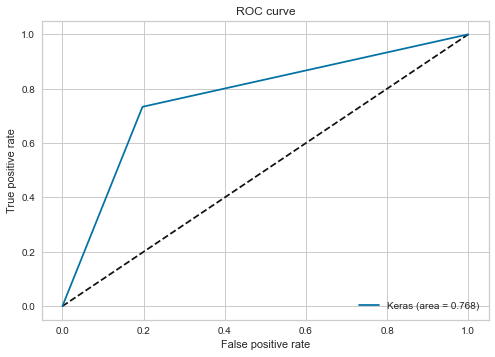

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


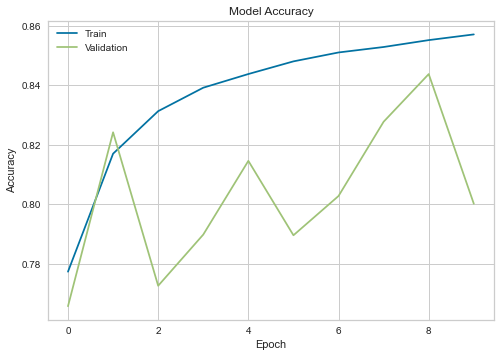

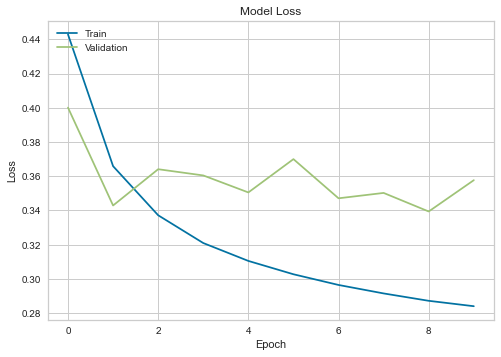

'\nplot_model(mod, to_file=\'model_plot.png\', show_shapes=True, show_layer_names=True)\nloss_train=nnHist.history[\'train_loss\']\nloss_val=nnHist.history[\'val_loss\']\nepochs=range(1,10)\nplt.plot(epochs, loss_train, \'g\', lebel=\'Training loss\')\nplt.plot(epochs,loss_val,\'b\',label=\'validation loss\')\nplt.title(\'Training and Validation loss\')\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Loss\')\nplt.legend()\nplt.show()\n\n\nloss_train = nnHist.history[\'accuracy\']\nloss_val = nnHist.history[\'val_accuracy\']\nepochs = range(1,11)\nplt.plot(epochs, loss_train, \'g\', label=\'Training accuracy\')\nplt.plot(epochs, loss_val, \'b\', label=\'validation accuracy\')\nplt.title(\'Training and Validation accuracy\')\nplt.xlabel(\'Epochs\')\nplt.ylabel(\'Accuracy\')\nplt.legend()\nplt.show() \n\n print("NN Added Weights")\nmod=NNetwork(X_train,Y_train,10,100,100,280,400,1)#train using the X_train and Y_train with epoch and first and second layers and specify 1 if weig\nprint("With balanced

In [38]:

#------------------------------------------------Neural Network Functions-------------------------------------#
#These are different functions to build and test out an Artifical Neural Network 
#There are functions to train the model, print training data, find accuaracy and other metrics and plot the layout of the NN
# Authors: Lucas Dillistone 
#------------------------------------------------------------------------------------------------------------#

#the NNetwork function will build and train a Neural Network 
#there will be 8 inputs but not all of them will be used. Tr is the predictor data, A is the response data E is the epochs L1-L4 are the different layer sizes but some may not be in use and W is a binary 0 or 1 to see if custom weights will need to be given to the answers 
#the output of this model is the NNModel that has been trained and the fitted model from the data 
def NNetwork(Tr,A,E,L1,L2,L3,L4,W):#Tr is training set A is answer L1 is layer 1 nodes L2 is layer 2 nodes E is the epochs and W is if weights are needed
    NNIn=Tr#take the data and use  new name for it 
    NNans=A
    ##########################################layers are added and removed here to test different implementations
    model_NN=Sequential()
    model_NN.add(Dense(L1, input_dim=NNIn.shape[1], activation='relu'))#50 nodes in first hidden layer there might have been an issue with relu but it seems to be fixed
    model_NN.add(Dropout(0.1))
    model_NN.add(Dense(L2, activation='relu'))
    #model_NN.add(Dense(L3, activation='relu',kernel_initializer='uniform'))
    
    #model_NN.add(Dense(L4, activation='relu'))#seems to bring back the all same value issue 
    #model_NN.add(Dropout(0.1))
    model_NN.add(Dense(1, activation='sigmoid'))
    model_NN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    #model_NN.compile(optimizer=sgd,loss='mse')##################################################try another optimizer
    if(W==1):#if the weights are needed or not 
        weights={0:(np.count_nonzero(NNans==1)/NNans.size), 1:(np.count_nonzero(NNans==0)/NNans.size)}#gives more even distribution less loss and not much difference in accuracy 
        #weights={0:7, 1:193}#increase to 27 gave slightly better results 
        nnHist=model_NN.fit(NNIn,NNans,class_weight=weights,epochs=E, validation_data=(X_test,Y_test))# it says 11073 insteead of 354324 because there are 32 batches and 354324/32=11073
        
    else: 
       nnHist=model_NN.fit(NNIn,NNans,epochs=E, validation_data=(X_test,Y_test))
    
   
    return model_NN, nnHist
    NNacc(model_NN,NNIn,NNans)#call the other function to analyze 


#this function can be called to display the accuracy and outputs of a model. The ROC curve will also be printed
#it will take three inputs model which is the trained model, testin which is the predictor values and testout which is the response values 
#there will be no return as the point is to output some results and plot the ROC curve 
def NNacc (model, testin,testout):
    predictions=model.predict_classes(testin)#make predictions 
    check=np.array(testout)#convert to an array 
    count=0#set the count for each varible to zero for later 
    count1=0
    count0=0
    for i in range(predictions.size):#Go through all of the values and see if it matched for the overall accuracy, see if both are 1 for accuracy of 1 and check if both are 0 for accuracy of 0
        if(predictions[i]==check[i]):
            count+=1
        if( predictions[i]==1 and check[i]==1):
            count1+=1
        if( predictions[i]==0 and check[i]==0):
            count0+=1 
    acc=((count/testout.size))*100
    acc1=(count1/np.count_nonzero(check==1))*100
    acc0=(count0/np.count_nonzero(check==0))*100
    print("Total accuracy: %d    Accuracy of predicting fraud: %d     Accuracy of predicting non-fraud: %d"%(round(acc),round(acc1),round(acc0)))#print the accuracy of each variable
    print("AUC %.4f"%(roc_auc_score(testout,predictions)))#ouput the ROC curve 

    #plot the roc curve
    fprK, tprK, threshK=roc_curve(testout,predictions)#get the ROC curve 
    aucK=auc(fprK,tprK)#find the AUC value
    plt.figure(1)#create and ouput the plot 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fprK, tprK, label='Keras (area = {:.3f})'.format(aucK))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()
    

#This function will plot the accuracy and loss of the model along with the validation for each value 
#it will take one value as input nnHist which is the history of fitting the model 
#there will be no return because the point is to just output some
def PlotHistory(nnHist):
    print(nnHist.history.keys())
    plt.plot(nnHist.history['accuracy'])
    plt.plot(nnHist.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    plt.plot(nnHist.history['loss'])
    plt.plot(nnHist.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
########################################### collection of different function calls to balance the data  
#bal_x, bal_y =smote(3,X_train,Y_train)#get more balanced data using smote with the input and output as well as the K value 

#ad_x,ad_y=ada(X_train,Y_train)#get more balanced data using ADASYN

#u_x,u_y=ENN(12,X_train,Y_train)

#CNN_x,CNN_y=CNN(1,X_train,Y_train)#relativly slow do not use again 

#NM_x, NM_y=NM(3,X_train,Y_train)#try this one if they still take a long time 

#ONN_x,ONN_y=OSS(4,200,X_train, Y_train)
#print("Done ENN")
#combination 

print("Combined")
mod,nnHist=NNetwork(comb_x,comb_y,10,500,500,25,400,0)#
#print("With balanced training data")
#NNacc(mod, comb_x,comb_y)
#print("With origional training data")
#NNacc(mod, X_train,Y_train)
print("with origional testing data")
NNacc(mod, X_test, Y_test) 
PlotHistory(nnHist)
plot_model(mod, to_file='model_plot.png', show_shapes=True, show_layer_names=True)#Plot the structure of the model and save it to a file called model_plot.png

In [ ]:
# [MODEL BUILDING]

algorithm = GradientBoostingClassifier()
parameters = {
    'n_estimators': [5, 50, 250, 500],
    'max_depth': [1, 3, 5, 7, 9],
    'learning_rate': [0.01, 0.1, 1, 10, 100]
}
cv = GridSearchCV(algorithm, parameters, cv=5)
cv.fit(X_train, Y_train.values.ravel())

In [ ]:
# [MODEL EVALUATION]
 
evaluate_model('Train Set', cv, X_train, Y_train)
evaluate_model('Validation Set', cv, X_validation, Y_validation)
evaluate_model('Test Set', cv, X_test, Y_test)